In [1]:
!pip show bitmap2svg

Name: bitmap2svg
Version: 0.2.3
Summary: A library to convert bitmaps to SVG, using C++ and OpenCV.
Home-page: https://github.com/Opensource-Nice-Arishi/kaggle_drawing_with_LLMs/tree/bitmap2svg
Author: 
Author-email: "Xiaonan (Nice) Wang" <wangxiaonannice@gmail.com>
License: MIT License

 Copyright (c) 2025 Opensource Nice & Arishi

 Permission is hereby granted, free of charge, to any person obtaining a copy
 of this software and associated documentation files (the "Software"), to deal
 in the Software without restriction, including without limitation the rights
 to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 copies of the Software, and to permit persons to whom the Software is
 furnished to do so, subject to the following conditions:

 The above copyright notice and this permission notice shall be included in all
 copies or substantial portions of the Software.

 THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 IMPLIED, INCLUDING

In [2]:
#| default_exp core

In [3]:
#| export

import kagglehub

import bitmap2svg

import os
import io
import re
import random
import base64
from io import BytesIO

import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from IPython.display import SVG

from PIL import Image
import cv2

from diffusers import StableDiffusionPipeline
from transformers import AutoProcessor, AutoModel

import logging
from lxml import etree

metric = kagglehub.package_import('nicecaliforniaw/forked-metric')

svg_constraints = kagglehub.package_import('metric/svg-constraints')

2025-05-28 17:43:42.268506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748454222.476314     145 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748454222.538451     145 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Installing python dependencies for Package 'kagglehub_package_nicecaliforniaw_forked_metric_4', logging progress to '/tmp/kagglehub-package-dependencies-install-z8zj7nsv.txt'.


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Competition Metric Helpers

See [metric package](https://www.kaggle.com/code/nicecaliforniaw/forked-metric).

In [4]:
import numpy as np
import statistics
import pandas as pd
import torch

def image_resize(image, size=(384, 384)):
    return image.convert('RGB').resize(size)

def bitmap_score_instance_impl(multiple_choice_qa, image, random_seed=42):
    rng = np.random.RandomState(random_seed)
    group_seed = rng.randint(0, np.iinfo(np.int32).max)
    image_processor = metric.ImageProcessor(image=image_resize(image), seed=group_seed).apply()
    image = image_processor.image.copy()
    questions = multiple_choice_qa['question']
    choices = multiple_choice_qa['choices']
    answers = multiple_choice_qa['answer']
    aesthetic_score = metric.aesthetic_evaluator.score(image)
    vqa_score = metric.vqa_evaluator.score(questions, choices, answers, image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    instance_score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
    return instance_score, vqa_score, ocr_score, aesthetic_score

def bitmap_score_instance(multiple_choice_qa, image, random_seed=42):
    torch.cuda.empty_cache()
    is_single = not isinstance(image, list)
    if is_single:
        multiple_choice_qa = [multiple_choice_qa]
        image = [image]
    
    assert len(multiple_choice_qa) == len(image)

    results = []
    score_df = []
    for one_image, one_multiple_choice_qa in zip(image, multiple_choice_qa, strict=True):
        instance_score, vqa_score, ocr_score, aesthetic_score = bitmap_score_instance_impl(one_multiple_choice_qa, one_image, random_seed=42)
        results.append(instance_score)
        score_df.append([instance_score, vqa_score, ocr_score, aesthetic_score])

    fidelity = statistics.mean(results)
    score_df = pd.DataFrame(score_df, columns=['competition_score', 'vqa_score', 'ocr_score', 'aesthetic_score'])
    if is_single:
        return score_df.iloc[0].to_dict()
    else:
        return float(fidelity), score_df

## Add OCR Decoy to SVG

In [5]:
#| export

import random
import re
from colorsys import rgb_to_hls, hls_to_rgb

def add_ocr_decoy_svg(svg_code: str) -> str:
    """
    Adds nested circles with second darkest and second brightest colors from the existing SVG,
    positioned in one of the four corners (randomly selected) but positioned to avoid being
    cropped out during image processing.
    
    Parameters:
    -----------
    svg_code : str
        The original SVG string
    
    Returns:
    --------
    str
        Modified SVG with the nested circles added
    """
    modified_svg = svg_code
    try:
        # Check if SVG has a closing tag
        if "</svg>" not in svg_code:
            return svg_code
        
        # Extract viewBox if it exists to understand the dimensions
        viewbox_match = re.search(r'viewBox=["\'](.*?)["\']', svg_code)
        if viewbox_match:
            viewbox = viewbox_match.group(1).split()
            try:
                x, y, width, height = map(float, viewbox)
            except ValueError:
                # Default dimensions if we can't parse viewBox
                width, height = 384, 384
        else:
            # Default dimensions if viewBox not found
            width, height = 384, 384
        
        # Function to convert hex color to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            if len(hex_color) == 3:
                hex_color = ''.join([c*2 for c in hex_color])
            return tuple(int(hex_color[i:i+2], 16)/255 for i in (0, 2, 4))
        
        # Function to convert RGB to hex
        def rgb_to_hex(rgb):
            return '#{:02x}{:02x}{:02x}'.format(
                int(rgb[0] * 255), 
                int(rgb[1] * 255), 
                int(rgb[2] * 255)
            )
        
        # Function to calculate color lightness
        def get_lightness(color):
            # Handle different color formats
            if color.startswith('#'):
                rgb = hex_to_rgb(color)
                return rgb_to_hls(*rgb)[1]  # Lightness is the second value in HLS
            elif color.startswith('rgb'):
                rgb_match = re.search(r'rgb\((\d+),\s*(\d+),\s*(\d+)\)', color)
                if rgb_match:
                    r, g, b = map(lambda x: int(x)/255, rgb_match.groups())
                    return rgb_to_hls(r, g, b)[1]
            return 0.5  # Default lightness if we can't parse
        
        # Extract all colors from the SVG
        color_matches = re.findall(r'(?:fill|stroke)="(#[0-9A-Fa-f]{3,6}|rgb\(\d+,\s*\d+,\s*\d+\))"', svg_code)
        
        # Default colors in case we don't find enough
        second_darkest_color = "#333333"  # Default to dark gray
        second_brightest_color = "#CCCCCC"  # Default to light gray
        
        if color_matches:
            # Remove duplicates and get unique colors
            unique_colors = list(set(color_matches))
            
            # Calculate lightness for each unique color
            colors_with_lightness = [(color, get_lightness(color)) for color in unique_colors]
            
            # Sort by lightness (brightness)
            sorted_colors = sorted(colors_with_lightness, key=lambda x: x[1])
            
            # Handle different scenarios based on number of unique colors
            if len(sorted_colors) >= 4:
                # We have at least 4 unique colors - use 2nd darkest and 2nd brightest
                second_darkest_color = sorted_colors[1][0]
                second_brightest_color = sorted_colors[-2][0]
            elif len(sorted_colors) == 3:
                # We have 3 unique colors - use 2nd darkest and brightest
                second_darkest_color = sorted_colors[1][0]
                second_brightest_color = sorted_colors[2][0]
            elif len(sorted_colors) == 2:
                # We have only 2 unique colors - use the darkest and brightest
                second_darkest_color = sorted_colors[0][0]
                second_brightest_color = sorted_colors[1][0]
            elif len(sorted_colors) == 1:
                # Only one color - use it for second_darkest and a derived lighter version
                base_color = sorted_colors[0][0]
                base_lightness = sorted_colors[0][1]
                second_darkest_color = base_color
                
                # Create a lighter color variant if the base is dark, or darker if base is light
                if base_lightness < 0.5:
                    # Base is dark, create lighter variant
                    second_brightest_color = "#CCCCCC"
                else:
                    # Base is light, create darker variant
                    second_darkest_color = "#333333"
        
        # Ensure the colors are different
        if second_darkest_color == second_brightest_color:
            # If they ended up the same, modify one of them
            if get_lightness(second_darkest_color) < 0.5:
                # It's a dark color, make the bright one lighter
                second_brightest_color = "#CCCCCC"
            else:
                # It's a light color, make the dark one darker
                second_darkest_color = "#333333"
        
        # Base size for the outer circle
        base_outer_radius = width * 0.023
        
        # Randomize size by ±10%
        size_variation = base_outer_radius * 0.1
        outer_radius = base_outer_radius + random.uniform(-size_variation, size_variation)
        
        # Define radii for inner circles based on outer radius
        middle_radius = outer_radius * 0.80
        inner_radius = middle_radius * 0.65
        
        # Calculate the maximum crop margin based on the image processing (5% of dimensions)
        # Add 20% extra margin for safety
        crop_margin_w = int(width * 0.05 * 1.2)
        crop_margin_h = int(height * 0.05 * 1.2)
        
        # Calculate center point based on the outer radius to ensure the entire circle stays visible
        safe_offset = outer_radius + max(crop_margin_w, crop_margin_h)
        
        # Choose a random corner (0: top-left, 1: top-right, 2: bottom-left, 3: bottom-right)
        corner = random.randint(0, 3)
        
        # Position the circle in the chosen corner, accounting for crop margin
        if corner == 0:  # Top-left
            center_x = safe_offset
            center_y = safe_offset
        elif corner == 1:  # Top-right
            center_x = width - safe_offset
            center_y = safe_offset
        elif corner == 2:  # Bottom-left
            center_x = safe_offset
            center_y = height - safe_offset
        else:  # Bottom-right
            center_x = width - safe_offset
            center_y = height - safe_offset
        
        # Add a small random offset (±10% of safe_offset) to make positioning less predictable
        random_offset = safe_offset * 0.1
        center_x += random.uniform(-random_offset, random_offset)
        center_y += random.uniform(-random_offset, random_offset)
        
        # Round to 1 decimal place to keep file size down
        outer_radius = round(outer_radius, 1)
        middle_radius = round(middle_radius, 1)
        inner_radius = round(inner_radius, 1)
        center_x = round(center_x, 1)
        center_y = round(center_y, 1)
        
        # Create the nested circles
        outer_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{outer_radius}" fill="{second_darkest_color}" />'
        middle_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{middle_radius}" fill="{second_brightest_color}" />'
        inner_circle = f'<circle cx="{center_x}" cy="{center_y}" r="{inner_radius}" fill="{second_darkest_color}" />'
        
        # Create a group element that contains all three circles
        group_element = f'<g>{outer_circle}{middle_circle}{inner_circle}</g>'
        
        # Insert the group element just before the closing SVG tag
        modified_svg = svg_code.replace("</svg>", f"{group_element}</svg>")
        
        # Calculate and add a comment with the byte size information
        outer_bytes = len(outer_circle.encode('utf-8'))
        middle_bytes = len(middle_circle.encode('utf-8'))
        inner_bytes = len(inner_circle.encode('utf-8'))
        total_bytes = outer_bytes + middle_bytes + inner_bytes
        
        corner_names = ["top-left", "top-right", "bottom-left", "bottom-right"]
        byte_info = f'<!-- Circle bytes: outer={outer_bytes}, middle={middle_bytes}, ' \
                    f'inner={inner_bytes}, total={total_bytes}, ' \
                    f'colors: dark={second_darkest_color}, light={second_brightest_color}, ' \
                    f'position: {corner_names[corner]} -->'
        
        modified_svg = modified_svg.replace("</svg>", f"{byte_info}</svg>")
    except Exception as e:
        print(e)
    return modified_svg

## Load Stable Diffusion

### Scheduler for Accelerating Sampling Process of Diffusion Model
#### `DDIMScheduler` vs `DPMSolverMultistepScheduler`
| Feature                     | DDIMScheduler                                  | DPMSolverMultistepScheduler (DPM-Solver++) |
| --------------------------- | --------------------------------------------- | --------------------------------------- |
| **Basic Principle** | Non-Markovian reverse process, deterministic sampling (controllable randomness) | Numerical ODE solving of diffusion (multi-step higher-order approximation) |
| **Efficiency (Steps)** | Fewer than DDPM, but potentially fewer than DPM-Solver++ | Typically fewer steps than DDIM to achieve good quality |
| **Randomness** | Controllable via the `eta` parameter          | Generally more deterministic              |
| **Generation Quality (same steps)** | Better than DDPM, potentially not as good as DPM-Solver++ | Often comparable to or better than DDIM    |
| **Implementation Complexity** | Relatively simple                               | Potentially more complex                  |

In [6]:
#| export
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# # ===== 1 =====

# import torch
# from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# # model_id = "/kaggle/input/stable-diffusion-v2/pytorch/1/1"
# model_id = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")

# # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
# pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe = pipe.to("cuda")

# ===== 2 =====

# Ensure GPU is being used and optimize for speed
device = "cuda:1" if torch.cuda.is_available() else "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, DPMSolverMultistepScheduler

# Load with optimized scheduler and half precision
stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")

# # DDIMScheduler
# scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")
# DPMSolverMultistepScheduler
scheduler = DPMSolverMultistepScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    stable_diffusion_path,
    scheduler=scheduler,
    torch_dtype=torch.float16,  # Use half precision
    safety_checker=None         # Disable safety checker for speed
)

# Move to GPU and apply optimizations
pipe.to(device) 

Using device: cuda:1


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "/kaggle/input/stable-diffusion-v2/pytorch/1/1",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Load Data

In [7]:
import pandas as pd
import json

In [8]:
drawing_with_llms_path = kagglehub.competition_download('drawing-with-llms')
train_df = pd.read_csv(f'{drawing_with_llms_path}/train.csv')
train_question_df = pd.read_parquet(f'{drawing_with_llms_path}/questions.parquet')

In [9]:
train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))
train_question_df = train_question_df.reset_index(name='qa')

train_question_df['question'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['question'], ensure_ascii=False))

train_question_df['choices'] = train_question_df.qa.apply(
    lambda qa: json.dumps(
        [x.tolist() for x in qa['choices']], ensure_ascii=False
    )
)

train_question_df['answer'] = train_question_df.qa.apply(lambda qa: json.dumps(qa['answer'], ensure_ascii=False))

train_df = pd.merge(train_df, train_question_df, how='left', on='id')

train_df['multiple_choice_qa'] = train_df.apply(
    lambda r: {
    'question': json.loads(r.question),
    'choices': json.loads(r.choices),
    'answer': json.loads(r.answer)
    },
    axis=1,
)

train_df.head()

/tmp/ipykernel_145/3218796089.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_question_df = train_question_df.groupby('id').apply(lambda df: df.to_dict(orient='list'))


id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

## Bitmap Generation
* Inference steps (more for better quality / slower)
* Guidance scale (how tightly to follow prompts)

In [10]:
#| export

def generate_bitmap(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=15, generator=torch.manual_seed(42)):
    with torch.no_grad(): 
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_inference_steps, 
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]
    torch.cuda.empty_cache()
    
    return image

# def generate_bitmap(prompt, negative_prompt="", num_inference_steps=20, guidance_scale=15):
#     with torch.no_grad(): 
#         image = pipe(
#             prompt=prompt,
#             negative_prompt=negative_prompt,
#             num_inference_steps=num_inference_steps, 
#             guidance_scale=guidance_scale
#         ).images[0]
#     torch.cuda.empty_cache()
    
#     return image

In [11]:
r = train_df.iloc[2]
description = r.description
print(description)

a lighthouse overlooking the ocean


In [12]:
prompt = f'{description}'
print(prompt)

a lighthouse overlooking the ocean


In [13]:
#| export

def get_aes_and_ocr_score(svg_content):
    image_processor = metric.ImageProcessor(image=metric.svg_to_png(svg_content), seed=33).apply()
    image = image_processor.image.copy()
    aesthetic_score = metric.aesthetic_evaluator.score(image)
    image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    # ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    ocr_score = 1.0
    return aesthetic_score, ocr_score

def get_vqa_aes_and_ocr_score(svg_content, questions_template, prompt):
    # image_processor = metric.ImageProcessor(image=metric.svg_to_png(svg_content), seed=33).apply()
    random_seed=42
    rng = np.random.RandomState(random_seed)
    group_seed = rng.randint(0, np.iinfo(np.int32).max)
    image_processor = metric.ImageProcessor(image=metric.svg_to_png(svg_content), seed=group_seed).apply()
    image = image_processor.image.copy()

    p_fidelity = metric.vqa_evaluator.score_yes_no(questions_template['fidelity'].format(prompt), image)
    vqa_score = p_fidelity

    aesthetic_score = 1.0
    # aesthetic_score = metric.aesthetic_evaluator.score(image)
    
    # image_processor.reset().apply_random_crop_resize().apply_jpeg_compression(quality=90)
    # ocr_score = metric.vqa_evaluator.ocr(image_processor.image)
    ocr_score = 1.0

    return vqa_score, aesthetic_score, ocr_score

## Implement the package Model class

In [14]:
#| export

class Model:
    def __init__(self):
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.prompt_prefix = "Simple, classic image of"
        self.prompt_suffix = "with flat color blocks, beautiful, minimal details, solid colors only"
        # self.negative_prompt = "lines, framing, hatching, background, textures, patterns, details, outlines"
        self.negative_prompt = ""

        self.questions_template = {
                'fidelity': 'Does <image> portray "SVG illustration of {}"? Answer yes or no.'                
        }

        self.num_inference_steps = 26
        self.guidance_scale = 20
        self.num_attempt = 4
        
        self.constraints = svg_constraints.SVGConstraints()

    # def gen_bitmap(self, description, generator):
    #     # prompt = f'{self.prompt_prefix} {description} {self.prompt_suffix}'
    #     prompt = f'{description}'
    #     bitmap = generate_bitmap(prompt, self.negative_prompt, self.num_inference_steps, self.guidance_scale, generator)
    #     return bitmap

    def gen_bitmap(self, description):
        # prompt = f'{self.prompt_prefix} {description} {self.prompt_suffix}'
        prompt = f'{description}'
        bitmap = generate_bitmap(prompt, self.negative_prompt, self.num_inference_steps, self.guidance_scale)
        return bitmap

    def predict_impl(self, prompt: str) -> str:
        best_score = 0.0
        best_svg = None
        best_img = None
        # base_seed = 42
        for i in range(self.num_attempt):
            # generator = torch.manual_seed(base_seed + i)
            # bitmap = self.gen_bitmap(prompt, generator)
            bitmap = self.gen_bitmap(prompt)
            # svg = bitmap_to_svg_layered(bitmap)
            try:
                # svg = bitmap2svg.bitmap_to_svg(bitmap)
                # svg = bitmap2svg.bitmap_to_svg(bitmap, min_contour_area=20.0, num_colors=8)
                svg = bitmap2svg.bitmap_to_svg(bitmap, num_colors=8)
            except Exception as e:
                svg = bitmap_to_svg_layered(bitmap) # use old version converter when exception occurs
            # aesthetic_score, ocr_score = get_aes_and_ocr_score(svg)
            # score = aesthetic_score * ocr_score
            svg = add_ocr_decoy_svg(svg)
            vqa_score, aesthetic_score, ocr_score = get_vqa_aes_and_ocr_score(svg, self.questions_template, prompt)
            # score = metric.harmonic_mean(vqa_score, aesthetic_score, beta=0.5) * ocr_score
            # score = vqa_score * ocr_score
            score = vqa_score
            if score >= best_score:
                best_score = score
                best_svg = svg
                best_img = bitmap
                print('update score:', best_score)
        
        if best_svg is None:
            best_svg = self.default_svg
        # else:
        #     best_svg = add_ocr_decoy_svg(best_svg)

        return best_svg, best_img

    def predict(self, prompt: str) -> str:
        try:
            svg, img = self.predict_impl(prompt)
            svg = self.enforce_constraints(svg)
        except Exception as e:
            return self.default_svg
        return svg
        
    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

In [15]:
model = Model()

In [16]:
import warnings

warnings.filterwarnings("ignore")

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.26434074380763156


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5814007049957399


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6316811847416601


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.7202140299517001
CPU times: user 41.1 s, sys: 15.9 s, total: 57 s
Wall time: 48.9 s


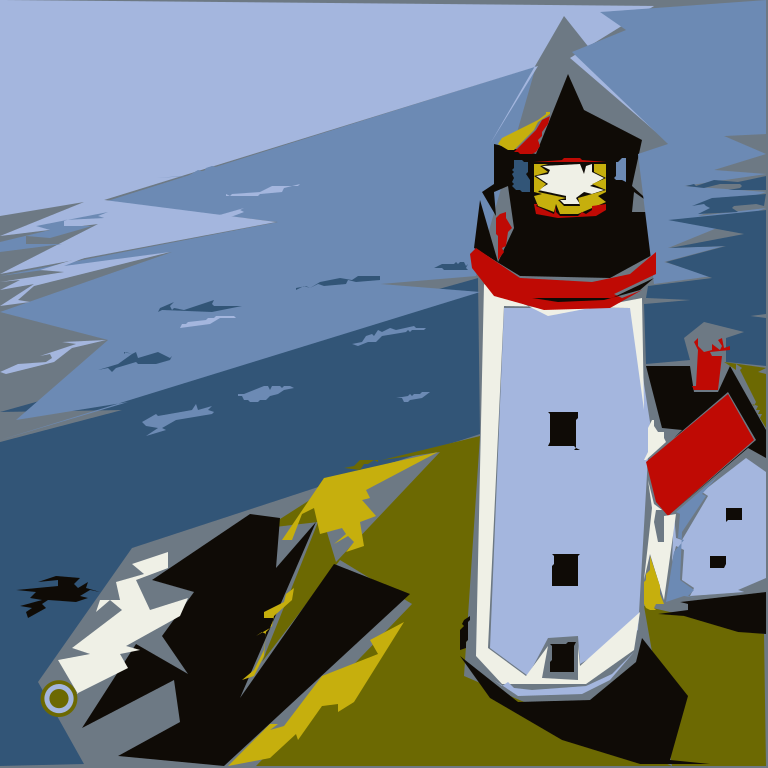

In [17]:
%%time
svg = model.predict(description)
SVG(svg)

In [18]:
metric.score_instance(r.multiple_choice_qa, svg, random_seed=42)

{'competition_score': 0.8263456437700358,
 'vqa_score': 0.9977131063657603,
 'ocr_score': 1.0,
 'aesthetic_score': 0.4898195266723633}

## Evaluate on train dataset

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [21]:
train_df.iloc[14]['description']

'a maroon dodecahedron interwoven with teal threads'

In [22]:
train_df.head()

id                                        description  \
0  02d892                            a purple forest at dusk   
1  0dcd2e              gray wool coat with a faux fur collar   
2  1e9ac1                 a lighthouse overlooking the ocean   
3  2b25db  burgundy corduroy pants with patch pockets and...   
4  4e6a54                           orange corduroy overalls   

                                                  qa  \
0  {'id': ['02d892', '02d892', '02d892', '02d892'...   
1  {'id': ['0dcd2e', '0dcd2e', '0dcd2e', '0dcd2e'...   
2  {'id': ['1e9ac1', '1e9ac1', '1e9ac1', '1e9ac1'...   
3  {'id': ['2b25db', '2b25db', '2b25db', '2b25db'...   
4  {'id': ['4e6a54', '4e6a54', '4e6a54', '4e6a54'...   

                                            question  \
0  ["What is the main setting of the image?", "Is...   
1  ["What color is the coat?", "What part of the ...   
2  ["Is there an ocean visible in the image?", "W...   
3  ["Are the pants yellow?", "Do the pants have p...   
4  ["What material is the item?", "Is a hat depic...   

                                             choices  \
0  [["beach", "desert", "forest", "mountain"], ["...   
1  [["blue", "brown", "gray", "red"], ["collar", ...   
2  [["no", "yes"], ["inside", "next to", "overloo...   
3  [["no", "yes"], ["no", "yes"], ["no", "yes"], ...   
4  [["corduroy", "denim", "leather", "silk"], ["n...   

                                  answer  \
0    ["forest", "yes", "dusk", "purple"]   
1       ["gray", "collar", "no", "wool"]   
2     ["yes", "overlooking", "no", "no"]   
3          ["no", "yes", "yes", "pants"]   
4  ["corduroy", "no", "yes", "overalls"]   

                                  multiple_choice_qa  
0  {'question': ['What is the main setting of the...  
1  {'question': ['What color is the coat?', 'What...  
2  {'question': ['Is there an ocean visible in th...  
3  {'question': ['Are the pants yellow?', 'Do the...  
4  {'question': ['What material is the item?', 'I...

In [23]:
%%time
train_df['raw_res'] = train_df.description.progress_apply(model.predict_impl)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6992179425466005


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.7041008082479172


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.3904766736734816


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.45325867678835985


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.47851571463942383


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6352534709163052


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6689447888655053


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.4980468829162098


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5019531168509614


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.7446278855829245


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5136718098077306


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.672362459361747


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5312498733406432


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.49609376955767615


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6619470139243531


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.7578115165271129


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5506465793358


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6808294830430031


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5717770186034791


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6842484031950526


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6020504041239586


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6723626648330754


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.726384377437599


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.2643406876360213


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.763484158290526


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.4746094839642736


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6261288395927836


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.422504576203456


  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.5467413399234962


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.6583633107572101


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

update score: 0.7387687912000929


  0%|          | 0/26 [00:00<?, ?it/s]

CPU times: user 10min 48s, sys: 4min 56s, total: 15min 45s
Wall time: 13min 44s


In [24]:
train_df['svg'] = train_df.raw_res.apply(lambda x: x[0])
train_df['bitmap'] = train_df.raw_res.apply(lambda x: x[1])

In [25]:
train_df['bitmap_score'] = train_df.progress_apply(
    lambda r: bitmap_score_instance(r.multiple_choice_qa, r.bitmap, random_seed=42),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

In [26]:
train_df['svg_score'] = train_df.progress_apply(
    lambda r: metric.score_instance(r.multiple_choice_qa, r.svg, random_seed=42),
    axis=1,
)

  0%|          | 0/15 [00:00<?, ?it/s]

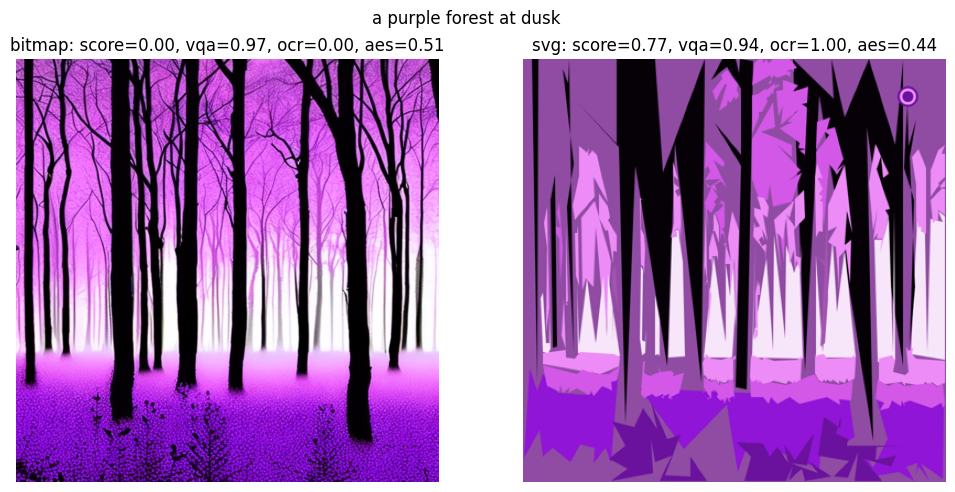

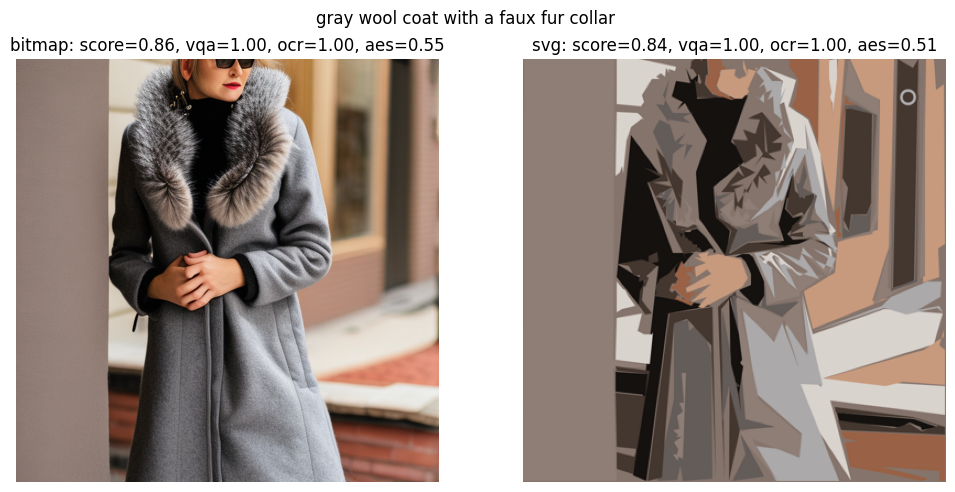

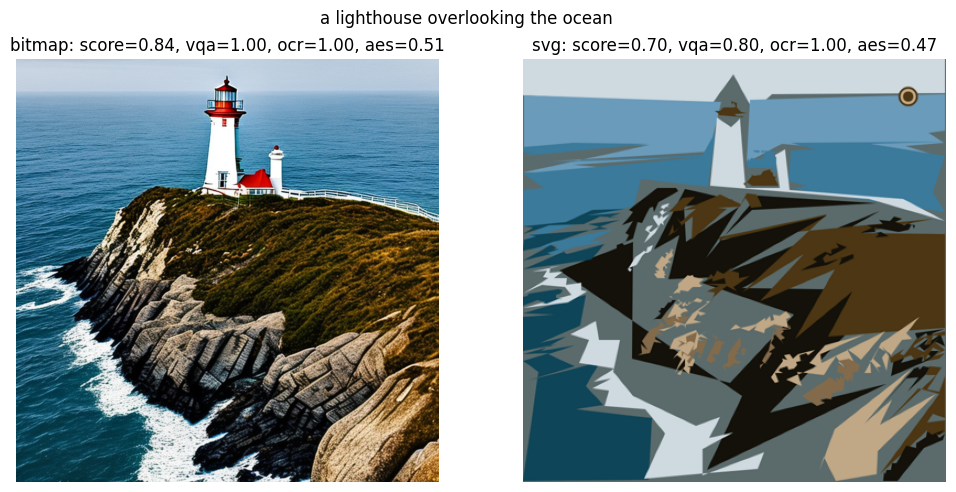

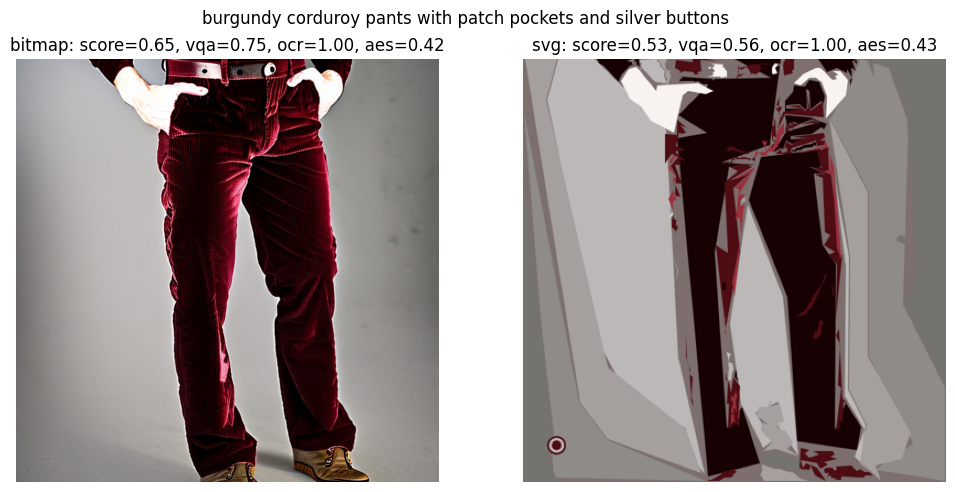

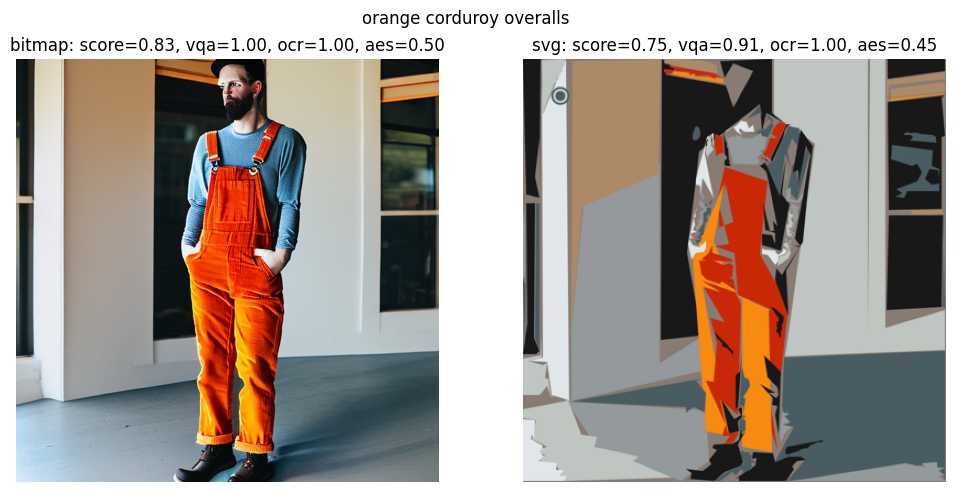

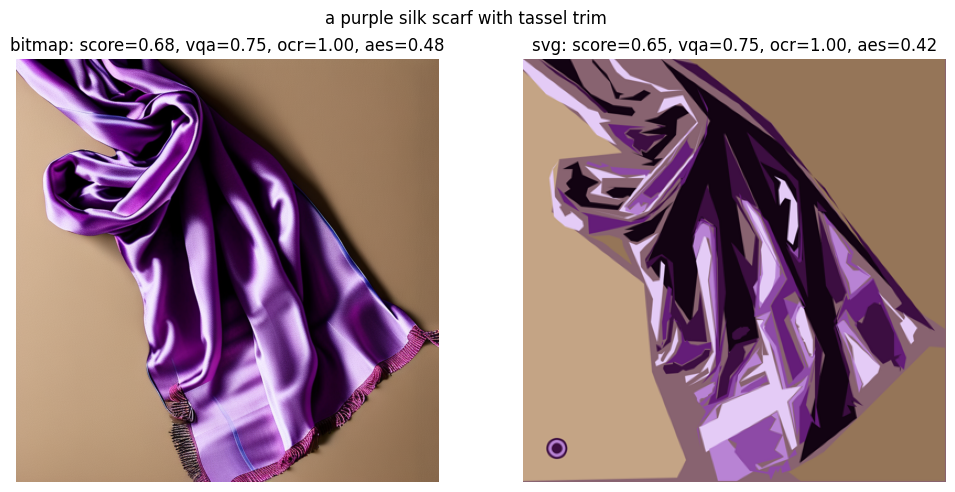

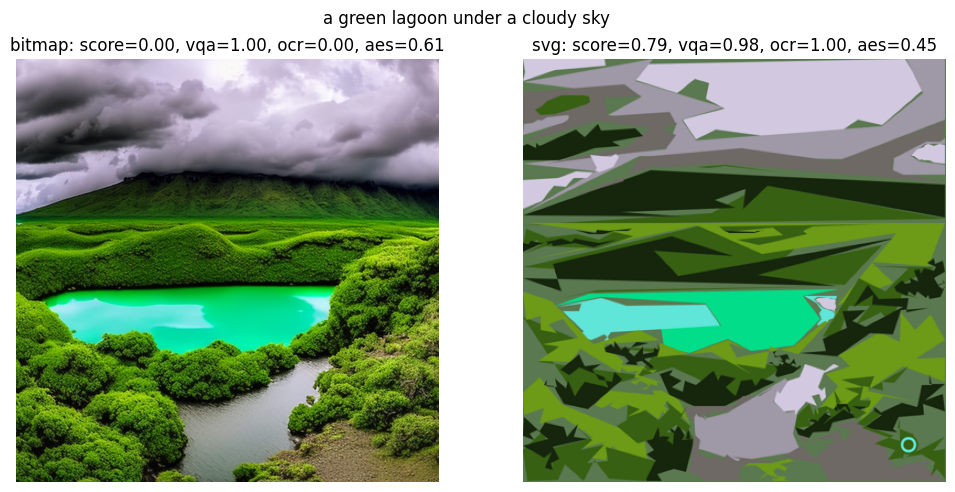

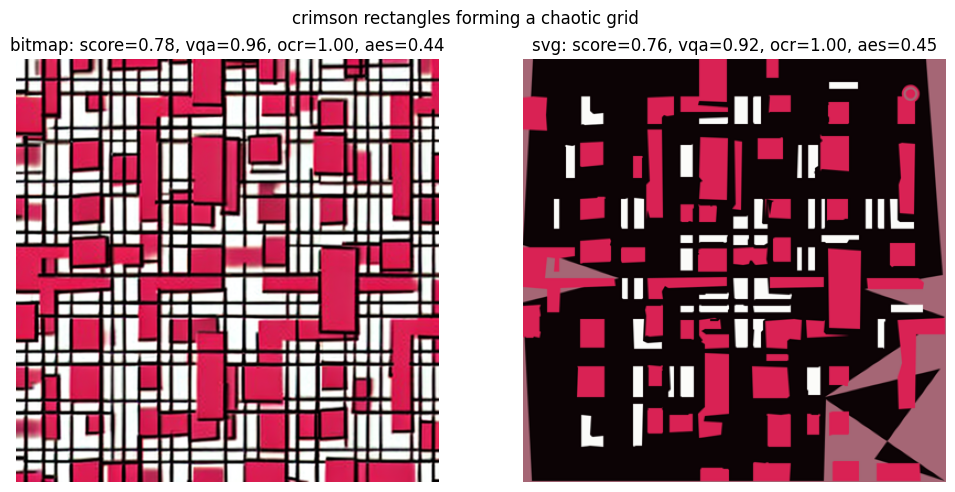

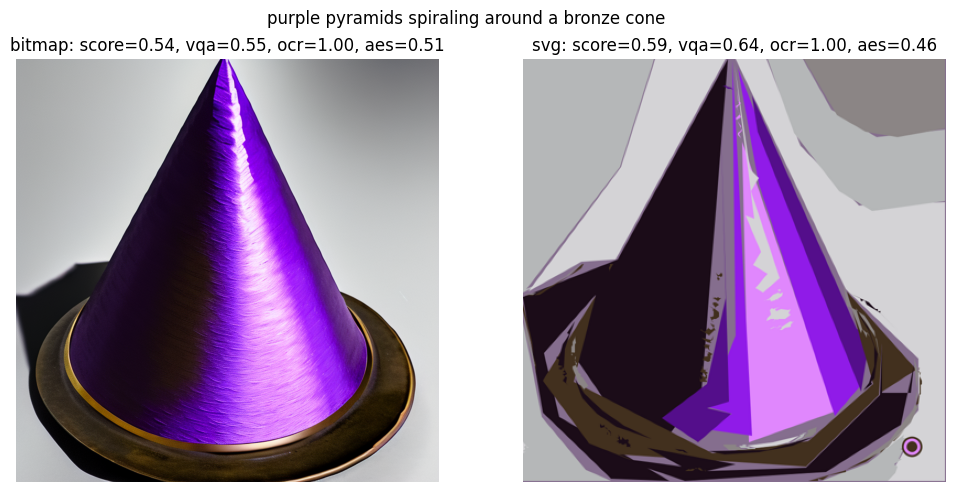

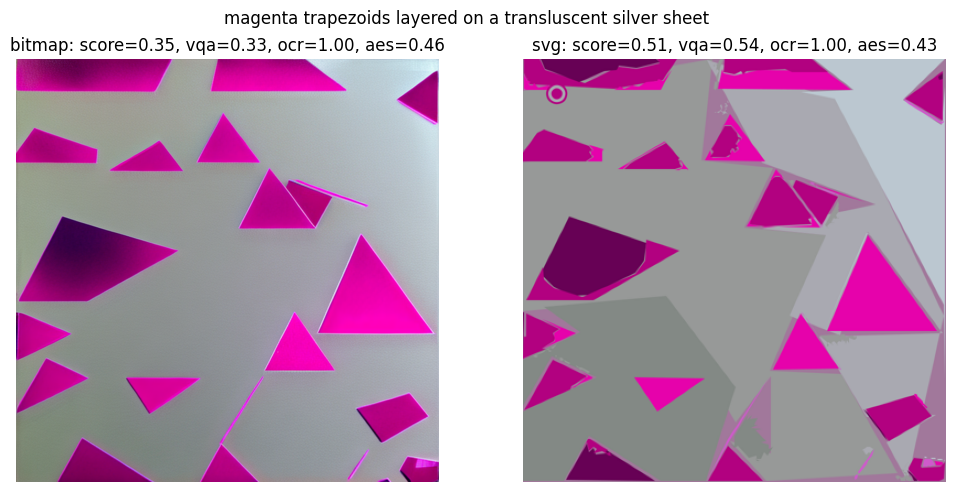

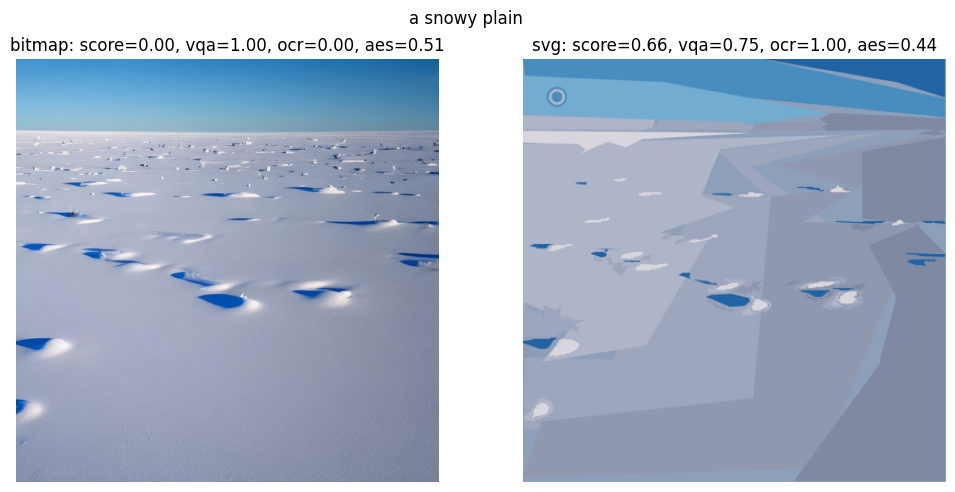

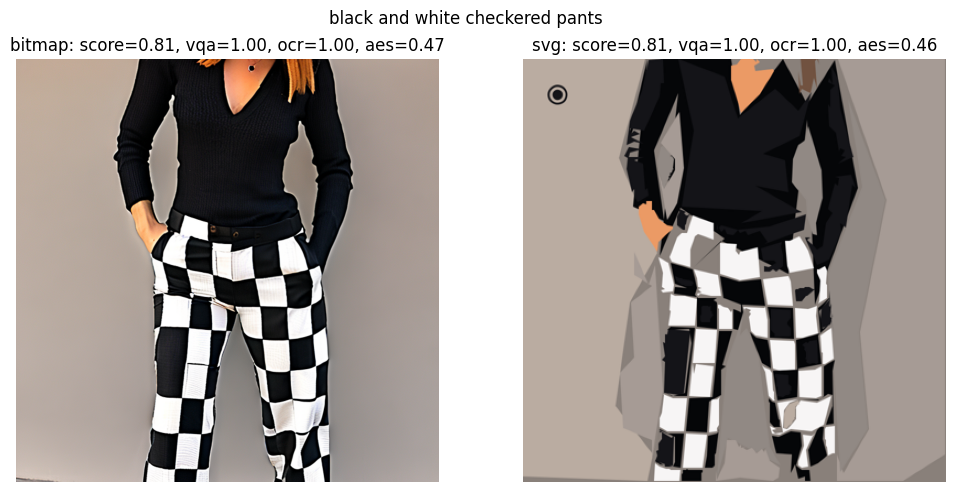

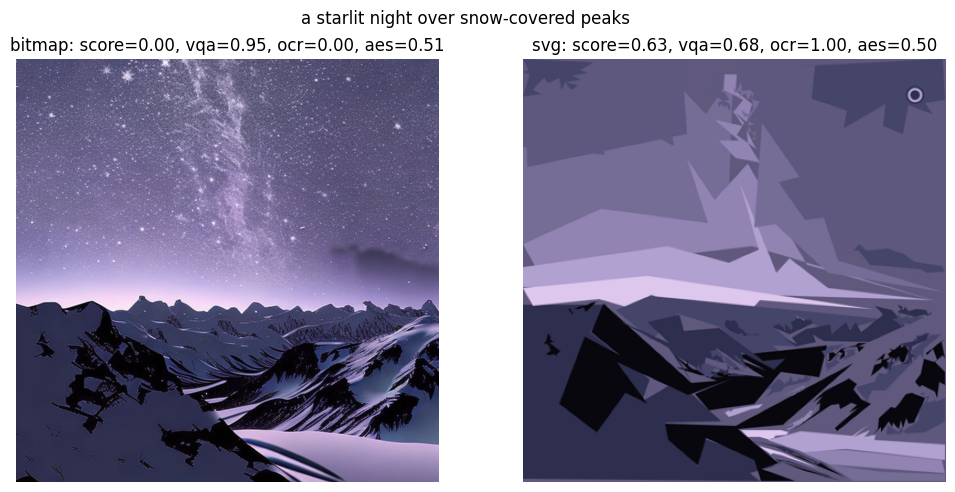

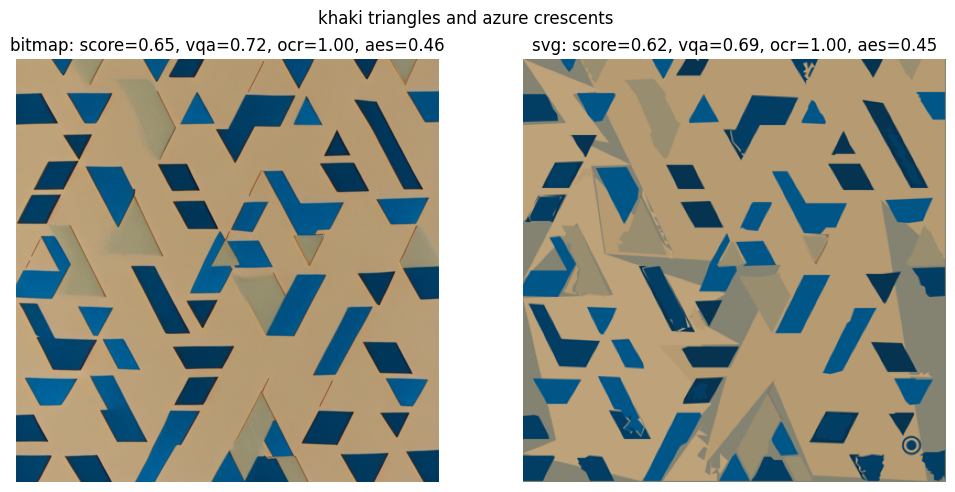

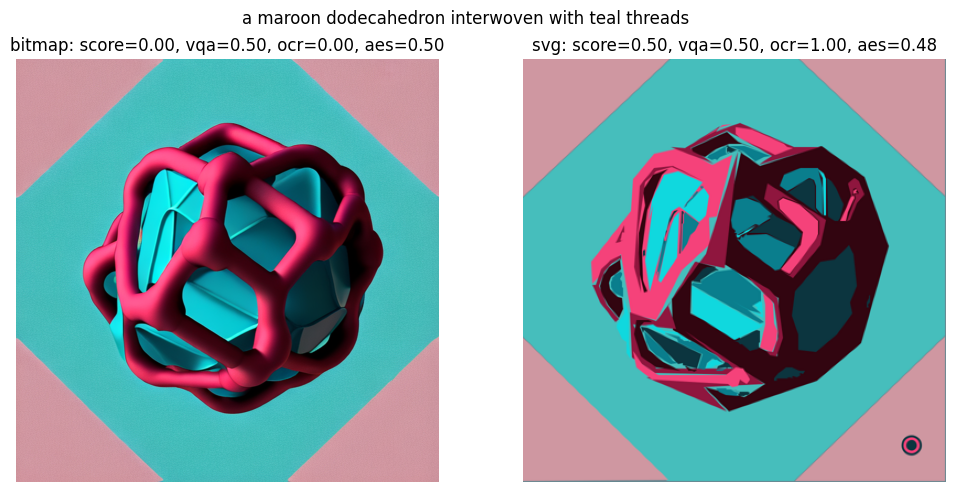

In [27]:
for r in train_df.itertuples():
    b_score = r.bitmap_score['competition_score']
    b_vqa = r.bitmap_score['vqa_score']
    b_ocr = r.bitmap_score['ocr_score']
    b_aesthetic = r.bitmap_score['aesthetic_score']

    s_score = r.svg_score['competition_score']
    s_vqa = r.svg_score['vqa_score']
    s_ocr = r.svg_score['ocr_score']
    s_aesthetic = r.svg_score['aesthetic_score']
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(r.description, y=0.93)
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(r.bitmap))
    plt.axis('off')
    plt.title(f'bitmap: score={b_score:.2f}, vqa={b_vqa:.2f}, ocr={b_ocr:.2f}, aes={b_aesthetic:.2f}')
    # plt.title(f'bitmap')

    plt.subplot(1, 2, 2)
    plt.imshow(metric.svg_to_png(r.svg))
    plt.axis('off')
    plt.title(f'svg: score={s_score:.2f}, vqa={s_vqa:.2f}, ocr={s_ocr:.2f}, aes={s_aesthetic:.2f}')
    # plt.title(f'svg')

In [28]:
mean_bitmap_score = pd.DataFrame(train_df['bitmap_score'].tolist()).mean(axis=0)
mean_bitmap_score

competition_score    0.465451
vqa_score            0.831703
ocr_score            0.666731
aesthetic_score      0.496234
dtype: float64

In [29]:
mean_svg_score = pd.DataFrame(train_df['svg_score'].tolist()).mean(axis=0)
mean_svg_score

competition_score    0.674229
vqa_score            0.776867
ocr_score            1.000000
aesthetic_score      0.455565
dtype: float64

In [30]:
print(f'Original bitmap score: {mean_bitmap_score.competition_score}')
print(f'Final svg score: {mean_svg_score.competition_score}')

Original bitmap score: 0.4654505374458103
Final svg score: 0.6742287549504417
